Epoch 0: Loss 1.6722
Epoch 20: Loss 0.4905
Epoch 40: Loss 0.2367
Epoch 60: Loss 0.1087
Epoch 80: Loss 0.1633
Epoch 100: Loss -0.0581
Epoch 120: Loss -0.0523
Epoch 140: Loss -0.0156
Epoch 160: Loss -0.0581
Epoch 180: Loss -0.0549
Epoch 200: Loss -0.0630
Epoch 220: Loss -0.0742
Epoch 240: Loss -0.0407
Epoch 260: Loss -0.0597
Epoch 280: Loss -0.0540
Epoch 300: Loss -0.1311
Epoch 320: Loss -0.0774
Epoch 340: Loss -0.1176
Epoch 360: Loss -0.1128
Epoch 380: Loss -0.2029
Epoch 400: Loss -0.2250
Epoch 420: Loss -0.0370
Epoch 440: Loss -0.2008
Epoch 460: Loss -0.1692
Epoch 480: Loss -0.1463
Epoch 500: Loss -0.1355
Epoch 520: Loss -0.1751
Epoch 540: Loss -0.1728
Epoch 560: Loss -0.1366
Epoch 580: Loss -0.2062
Epoch 600: Loss -0.2491
Epoch 620: Loss -0.2222
Epoch 640: Loss -0.2133
Epoch 660: Loss -0.1603
Epoch 680: Loss -0.1768
Epoch 700: Loss -0.2367
Epoch 720: Loss -0.1540
Epoch 740: Loss -0.1423
Epoch 760: Loss -0.2563
Epoch 780: Loss -0.0845
Epoch 800: Loss -0.2922
Epoch 820: Loss -0.1819
Epo

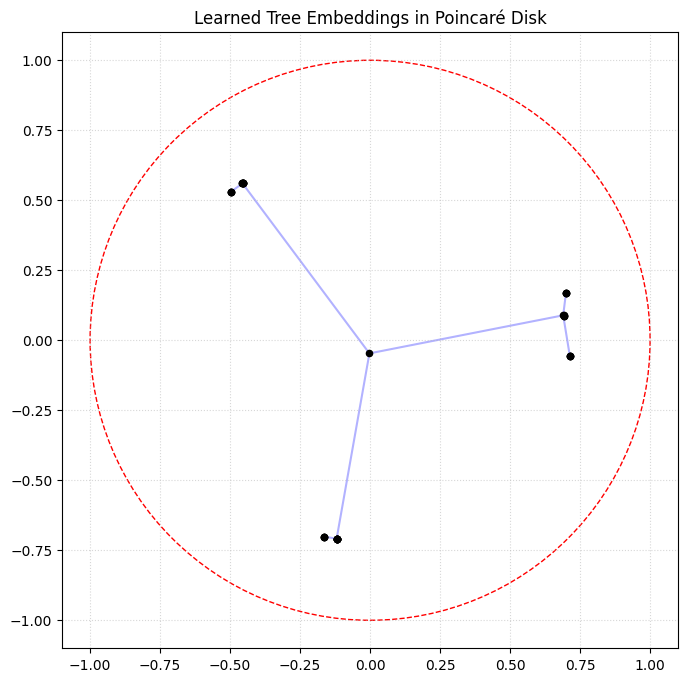

In [23]:
import torch
import torch.nn as nn

class PoincareManifold:
    def __init__(self, c=5.0):
        self.c = c  

    def mobius_add(self, x, y):
        # Using x.pow(2).sum... is slightly more efficient in Torch
        x2 = torch.sum(x * x, dim=-1, keepdim=True)
        y2 = torch.sum(y * y, dim=-1, keepdim=True)
        xy = torch.sum(x * y, dim=-1, keepdim=True)
        
        num = (1 + 2 * self.c * xy + self.c * y2) * x + (1 - self.c * x2) * y
        denom = 1 + 2 * self.c * xy + self.c**2 * x2 * y2
        return num / torch.clamp(denom, min=1e-15)

    def exp_map(self, p, v):
        # Ensure p is a tensor on the same device as v
        if isinstance(p, (int, float)) and p == 0:
            p = torch.zeros_like(v)
            
        v_norm = torch.norm(v, p=2, dim=-1, keepdim=True).clamp(min=1e-10)
        sqrt_c = torch.sqrt(torch.tensor(self.c, device=v.device, dtype=v.dtype))
        
        # Now this will work because p is a Tensor
        p_norm_sq = torch.sum(p * p, dim=-1, keepdim=True)
        lambda_p = 2 / (1 - self.c * p_norm_sq)
        
        v_at_origin = torch.tanh(sqrt_c * lambda_p * v_norm / 2) * v / (sqrt_c * v_norm)
        
        # Using a small epsilon or torch.allclose is safer for tensors
        if torch.all(p == 0):
            return v_at_origin
        return self.mobius_add(p, v_at_origin)

    def log_map(self, p, x):
        # 1. Mobius subtraction: move x to origin relative to p
        x_transformed = self.mobius_add(-p, x)
        
        sqrt_c = torch.sqrt(torch.tensor(self.c, device=x.device, dtype=x.dtype))
        x_norm = torch.norm(x_transformed, p=2, dim=-1, keepdim=True).clamp(min=1e-10)
        
        p_norm_sq = torch.sum(p * p, dim=-1, keepdim=True)
        lambda_p = 2 / (1 - self.c * p_norm_sq)
        
        # Clamp for numerical stability
        arg = (sqrt_c * x_norm).clamp(max=1 - 1e-7)
        scalar = (2 / (lambda_p * sqrt_c * x_norm)) * torch.atanh(arg)
        return scalar * x_transformed

    def dist(self, x, y):
        sq_dist = torch.norm(x - y, p=2, dim=-1)**2
        nx = 1 - self.c * torch.norm(x, p=2, dim=-1)**2
        ny = 1 - self.c * torch.norm(y, p=2, dim=-1)**2
        val = 1 + 2 * self.c * sq_dist / (nx.clamp(min=1e-15) * ny.clamp(min=1e-15))
        return (1 / torch.sqrt(torch.tensor(self.c))) * torch.acosh(val.clamp(min=1 + 1e-7))

#####################################################################################################

class RiemannianEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, manifold):
        super().__init__()
        self.manifold = manifold
        # Initialize embeddings with small values to stay near the origin (North Pole)
        self.weight = nn.Parameter(torch.randn(vocab_size, embed_dim) * 0.01)

    def forward(self, x):
        # We treat the raw weights as being in the tangent space at the origin
        # and project them onto the 'Curly' manifold.
        raw_vecs = self.weight[x]
        return self.manifold.exp_map(p=0, v=raw_vecs)

#####################################################################################################

class MobiusLinear(nn.Module):
    def __init__(self, in_features, out_features, manifold):
        super().__init__()
        self.manifold = manifold
        # Weights are Euclidean; they live in the tangent space
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        # 1. Log map to tangent space (at origin)
        x_tangent = self.manifold.log_map(p=torch.zeros_like(x), x=x)
    
        # 2. Matrix multiplication
        res_tangent = torch.matmul(x_tangent, self.weight.t())
    
        # 3. Exp map back to manifold
        res_manifold = self.manifold.exp_map(p=torch.zeros_like(res_tangent), v=res_tangent)
    
        # 4. Apply Hyperbolic Bias
        # Project bias onto manifold first (exp_map at origin)
        bias_manifold = self.manifold.exp_map(p=torch.zeros_like(self.bias), v=self.bias)
        return self.manifold.mobius_add(res_manifold, bias_manifold)

######################################################################################################

class RSGD(torch.optim.Optimizer):
    def __init__(self, params, lr, manifold):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        defaults = dict(lr=lr, manifold=manifold)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            manifold = group['manifold']
            lr = group['lr']

            for p in group['params']:
                if p.grad is None:
                    continue
                
                # 1. Compute the Riemannian Gradient
                # For the Poincare ball, this is: grad_euclidean * (1/lambda_p)^2
                # lambda_p = 2 / (1 - c|p|^2)
                p_sq_norm = torch.sum(p.data**2, dim=-1, keepdim=True)
                rescale_factor = ((1 - manifold.c * p_sq_norm)**2) / 4
                riemannian_grad = p.grad.data * rescale_factor

                # 2. Update via Exponential Map
                # Move p in the direction of -riemannian_grad
                p.data = manifold.exp_map(p=p.data, v=-lr * riemannian_grad)
                
                # 3. Projection (Safety first!)
                # Ensure the point stays strictly inside the ball radius (1/sqrt(c))
                max_norm = (1 - 1e-5) / torch.sqrt(torch.tensor(manifold.c))
                p_norm = torch.norm(p.data, p=2, dim=-1, keepdim=True)
                cond = p_norm >= max_norm
                if cond.any():
                    projected = p.data / p_norm * max_norm
                    p.data = torch.where(cond, projected, p.data)

        return loss

##############################################################################################

# Clear the previous lists
manifold_params = []
euclidean_params = []

for name, param in model.named_parameters():
    # In this specific case, the weights ARE the manifold points
    # because they get passed through the exp_map.
    if 'weight' in name:
        manifold_params.append(param)
    else:
        euclidean_params.append(param)

# Check if we have anything for Adam (optional, to prevent future errors)
if euclidean_params:
    optimizer_euclidean = torch.optim.Adam(euclidean_params, lr=0.001)
else:
    optimizer_euclidean = None


lr = 0.5
# This should now work because manifold_params contains the weights!
optimizer_manifold = RSGD(manifold_params, lr=0.01, manifold=manifold)

##############################################################################################

import networkx as nx
import torch
import numpy as np

# Create a balanced tree: branching factor 3, depth 3
# This creates 40 nodes total
G = nx.balanced_tree(r=3, h=3)
nodes = list(G.nodes())
edges = list(G.edges())

# We want to predict neighbors, so our 'X' is node A and 'Y' is node B
# Convert edges to a tensor of indices
edge_index = torch.tensor(edges, dtype=torch.long)

###########################################################################################

# Hyperparameters
vocab_size = len(nodes)
embed_dim = 2  # 2D so we can plot it easily on the disk!
lr = 1

# Initialize our components
manifold = PoincareManifold(c=1.0)
model = RiemannianEmbedding(vocab_size, embed_dim, manifold)
optimizer = RSGD(model.parameters(), lr=lr, manifold=manifold)

# Updated Training Loop with "Push-Pull" logic
for epoch in range(1000): # Increased epochs
    optimizer.zero_grad()
    
    # 1. Attraction: Neighbors should be close
    u_idx, v_idx = edge_index[:, 0], edge_index[:, 1]
    dist_pos = manifold.dist(model(u_idx), model(v_idx))
    
    # 2. Repulsion: Random nodes should be far apart (Contrastive)
    # Pick random indices to push away
    random_idx = torch.randint(0, vocab_size, (u_idx.size(0),))
    dist_neg = manifold.dist(model(u_idx), model(random_idx))
    
    # Loss: minimize neighbor dist, maximize random dist (up to a margin)
    # We use a Margin Loss style here
    loss = dist_pos.mean() - 0.5 * torch.log(dist_neg.mean() + 1e-6)
    loss += 0.1 * manifold.dist(model(torch.tensor([0])), torch.zeros(1, 2)).mean()
    
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f}")

##################################################################################################

import matplotlib.pyplot as plt

def plot_poincare_tree(model, edge_index):
    # Get the trained weights (which are now points on the manifold)
    # We run them through the exp_map(p=0) just like in the forward pass
    with torch.no_grad():
        embeddings = model.manifold.exp_map(p=0, v=model.weight).cpu().numpy()

    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Draw the boundary of the Poincare Disk
    circle = plt.Circle((0, 0), 1.0, color='r', fill=False, linestyle='--', label='Boundary')
    ax.add_artist(circle)
    
    # Plot the edges
    for i in range(edge_index.shape[0]):
        u_idx, v_idx = edge_index[i]
        u_pos = embeddings[u_idx]
        v_pos = embeddings[v_idx]
        ax.plot([u_pos[0], v_pos[0]], [u_pos[1], v_pos[1]], color='blue', alpha=0.3, zorder=1)
    
    # Plot the nodes
    ax.scatter(embeddings[:, 0], embeddings[:, 1], c='black', s=20, zorder=2)
    
    # Formatting
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal')
    ax.set_title("Learned Tree Embeddings in Poincaré Disk")
    plt.grid(True, which='both', linestyle=':', alpha=0.5)
    plt.show()

# Run this after your training loop
plot_poincare_tree(model, edge_index)
